# **スペインの保険データ**
Source: https://data.mendeley.com/datasets/vfchtm5y7j/1

## 1.0 概要
スペインの保険会社の実データであり、自動車保険と住宅保険（homeowners）の双方を契約する40,284人の個人保険契約者の5年間の追跡データ（一部の顧客は保険契約を更新しないため、5年間分のサンプルがないものもある）。各顧客の情報、契約内容、契約の種類ごとの年間クレーム額（ユーロ）が記録されている。自動車保険では、クレーム額は過失分のみが考慮されている。

論文: https://www.sciencedirect.com/science/article/pii/S0957417421009581
にて構築されたデータであり、当論文では契約失効率の分析が行われているが、料率設定の演習にも活用できそうと判断。

なお、住宅保険については家財および建物の保険価額が記録されているが、クレーム額は合計値のみの記載であるため使用しづらいと判断し、自動車保険のデータのみを使用することを考えている。

## 2.0 特徴量

（これらのうち自動車保険に関連するもののみを使用）

- PolID: 顧客ID
- year: 観察年
- gender: 1=男性 0=女性
- Age_client: 契約者の年齢
- age_of_car_M: 自動車を購入してからの経過年数
- Car_power_M: 自動車の「power」
- Car_2ndDriver_M: 1=第二の運転者がいることを保険会社に通知済み 0=それ以外
- num_policiesC: 当保険会社における当契約者の契約件数
- metro_code: 1=都市 0=田舎（rural）
- Policy_PaymentMethodA: 1=保険料年払い 0=保険料月払い　（自動車保険）
- Policy_PaymentMethodH: 1=保険料年払い 0=保険料月払い　（住宅保険）
- Insuredcapital_content_re: 家財の保険価額（住宅保険）
- Insuredcapital_continent_re: 建物の保険価額（住宅保険）
- appartment: 1=アパートメント 0:その他
- Client_Seniority: 当契約者が当保険会社と契約してからの年数
- Retention: 1=更新契約 0=その他の契約
- NClaims1: 当年における合計クレーム数（自動車保険）
- NClaims2: 当年における合計クレーム数（住宅保険）
- Claims1: 当年における合計クレーム額（自動車保険）
- Claims2: 当年における合計クレーム額（住宅保険）
- Types: 当年において、1=自動車保険・住宅保険ともにクレームなしの場合, 2=自動車保険はクレームありで住宅保険はクレームなしの場合, 3=住宅保険はクレームありで自動車保険はクレームなしの場合, 4:自動車保険・住宅保険ともにクレームありの場合

## 3.0 EDA

In [28]:
library(skimr)
library(ggplot2)
library(psych)
library(dplyr)
library(gridExtra)
options(warn=-1, message=-1)

In [29]:
dir_home <- "/Users/nkato/Documents/Waseda/sonpo-pricing-2023"
setwd(dir_home)

In [30]:
df <- read.csv('./dataset/data_ex.csv')
columns_for_auto <- c(
    "PolID",
    "year",
    "gender",
    "Age_client",
    "age_of_car_M",
    "Car_power_M",
    "Car_2ndDriver_M",
    "metro_code",
    "NClaims1",
    "Claims1"
)
df <- df[, columns_for_auto]
# add claim size
df <- df %>% mutate(average_Claims1 = ifelse(NClaims1>0, Claims1/NClaims1, 0))

In [31]:
str(df)

'data.frame':	122935 obs. of  11 variables:
 $ PolID          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ year           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ gender         : int  1 1 1 1 1 0 1 1 1 1 ...
 $ Age_client     : int  84 83 85 85 82 79 79 85 78 82 ...
 $ age_of_car_M   : int  13 0 0 0 20 8 10 10 8 6 ...
 $ Car_power_M    : num  90 177 163 90 115 75 200 70 115 105 ...
 $ Car_2ndDriver_M: int  0 0 0 0 0 0 0 0 0 0 ...
 $ metro_code     : int  0 0 0 0 0 1 0 0 1 0 ...
 $ NClaims1       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Claims1        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ average_Claims1: num  0 0 0 0 0 0 0 0 0 0 ...


In [32]:
skim(df)

,skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,numeric,PolID,0,1,2.007929e+04,1.172919e+04,1,9799,20087,30221,40284.00,▇▇▇▇▇
2,numeric,year,0,1,2.456835e+00,1.352461e+00,1,1,2,3,5.00,▇▆▅▃▂
3,numeric,gender,0,1,7.782243e-01,4.154427e-01,0,1,1,1,1.00,▂▁▁▁▇
4,numeric,Age_client,0,1,5.966586e+01,1.294859e+01,18,50,59,70,95.00,▁▃▇▆▂
5,numeric,age_of_car_M,0,1,8.849612e+00,6.214193e+00,0,4,9,13,68.00,▇▂▁▁▁
6,numeric,Car_power_M,0,1,1.115323e+02,4.441374e+01,4,82,105,130,560.00,▇▃▁▁▁
7,numeric,Car_2ndDriver_M,0,1,1.384960e-01,3.454212e-01,0,0,0,0,1.00,▇▁▁▁▁
8,numeric,metro_code,0,1,1.635905e-01,3.699051e-01,0,0,0,0,1.00,▇▁▁▁▂
9,numeric,NClaims1,0,1,2.977183e-02,2.030210e-01,0,0,0,0,6.00,▇▁▁▁▁


── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             122935
Number of columns          11    
_______________________          
Column type frequency:           
  numeric                  11    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable   n_missing complete_rate       mean        sd p0  p25   p50
 1 PolID                   0             1 20079.     11729.     1 9799 20087
 2 year                    0             1     2.46       1.35   1    1     2
 3 gender                  0             1     0.778      0.415  0    1     1
 4 Age_client              0             1    59.7       12.9   18   50    59
 5 age_of_car_M            0             1     8.85       6.21   0    4     9
 6 Car_power_M             0             1   112.        44.4    4   82   105
 7 Car_2ndDriver_M       

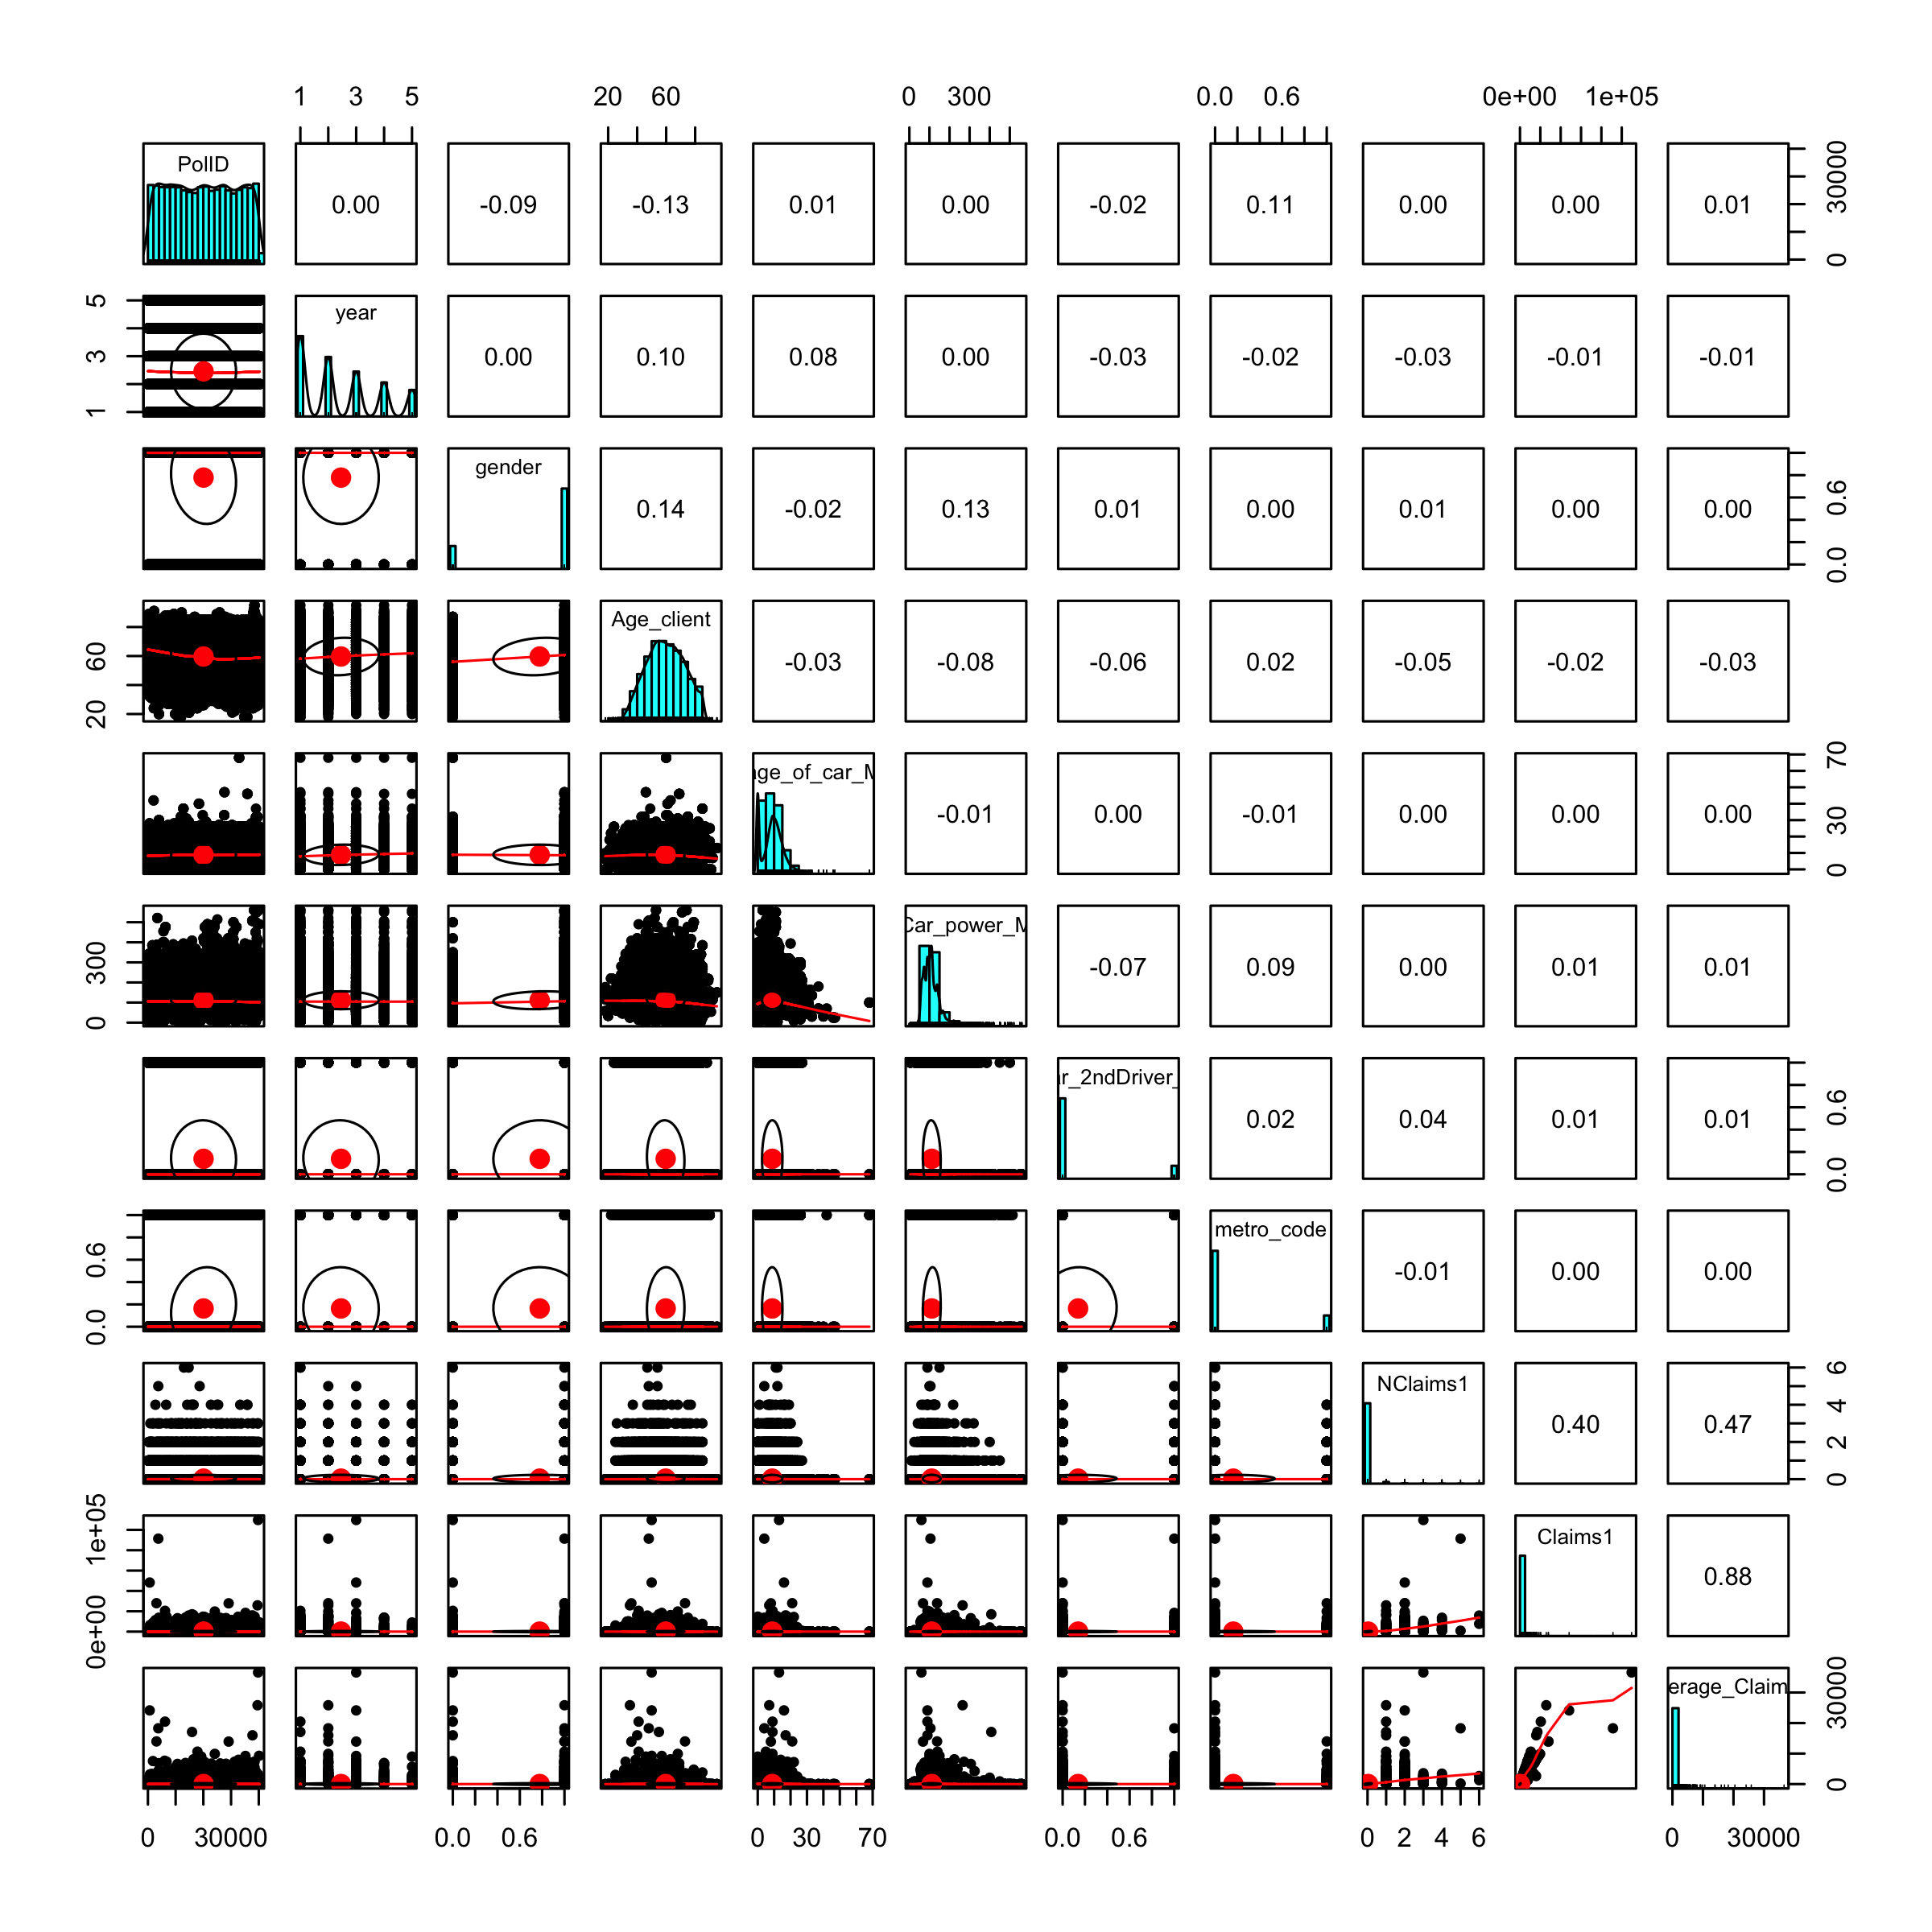

In [33]:
# pair plot
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res = 300)
pairs.panels(df)

In [34]:
# visualize column_y and its exposure by column_x
visualize_barplot <- function(df, column_y, column_x){
    # summarize df by column_x
    df2 <- df %>%
      select({{column_x}}, {{column_y}}) %>%
      group_by_at({{column_x}}) %>%
      summarize(freq=mean(.data[[column_y]]), total=n())
    # plotting
    p_freq <- df2 %>%
      ggplot(aes(x = .data[[column_x]])) +
      geom_line(mapping = aes(y = freq)) +
      labs(x=column_x, y=paste("mean", column_y))
    p_total <- df2 %>%
      ggplot(aes(x = .data[[column_x]])) +
      geom_col(mapping = aes(y = total)) +
      labs(x=column_x, y="total exposure")
    #grid.arrange(p_freq, p_total, nrow=2, top=paste(column_x, "vs", column_y))
    return(list("freq" = p_freq, "exposure" = p_total))
    }

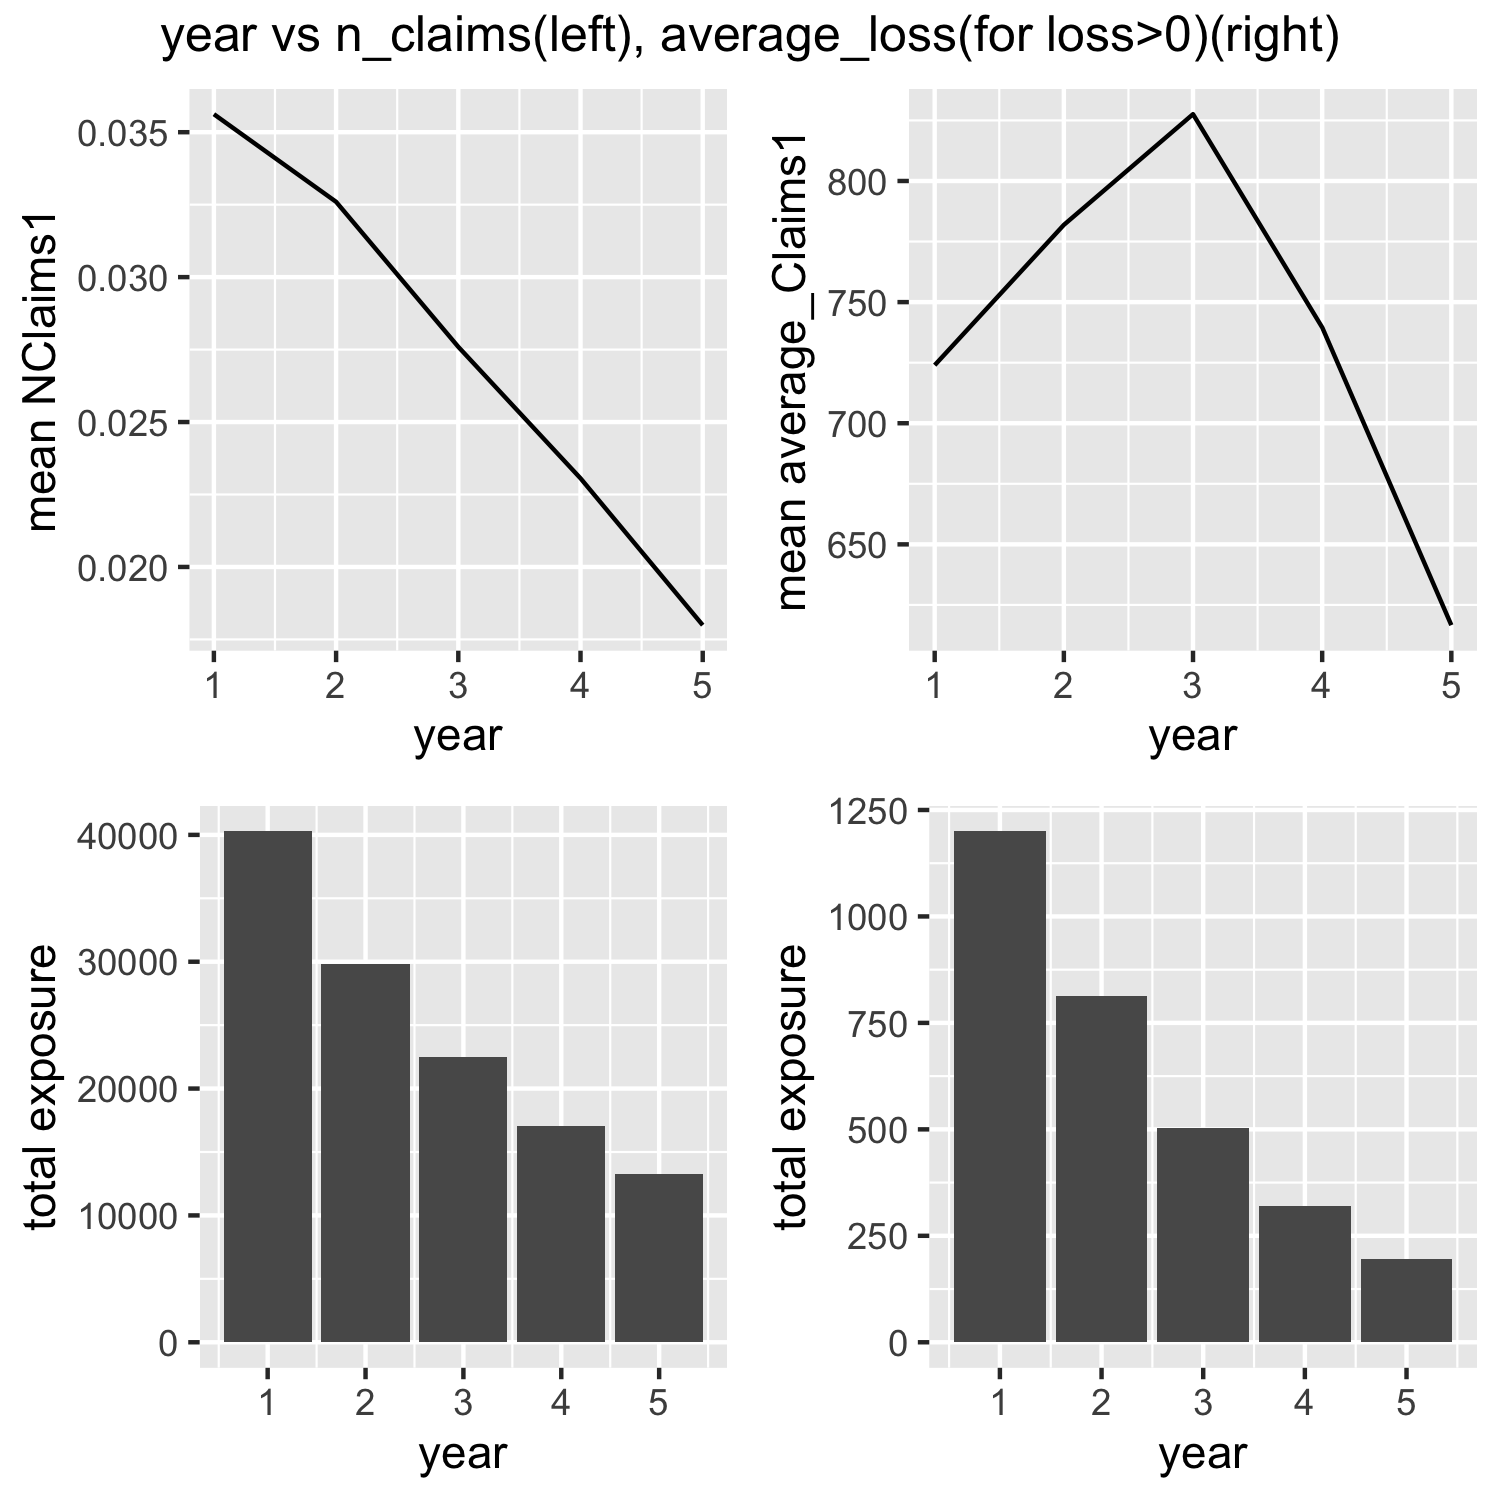

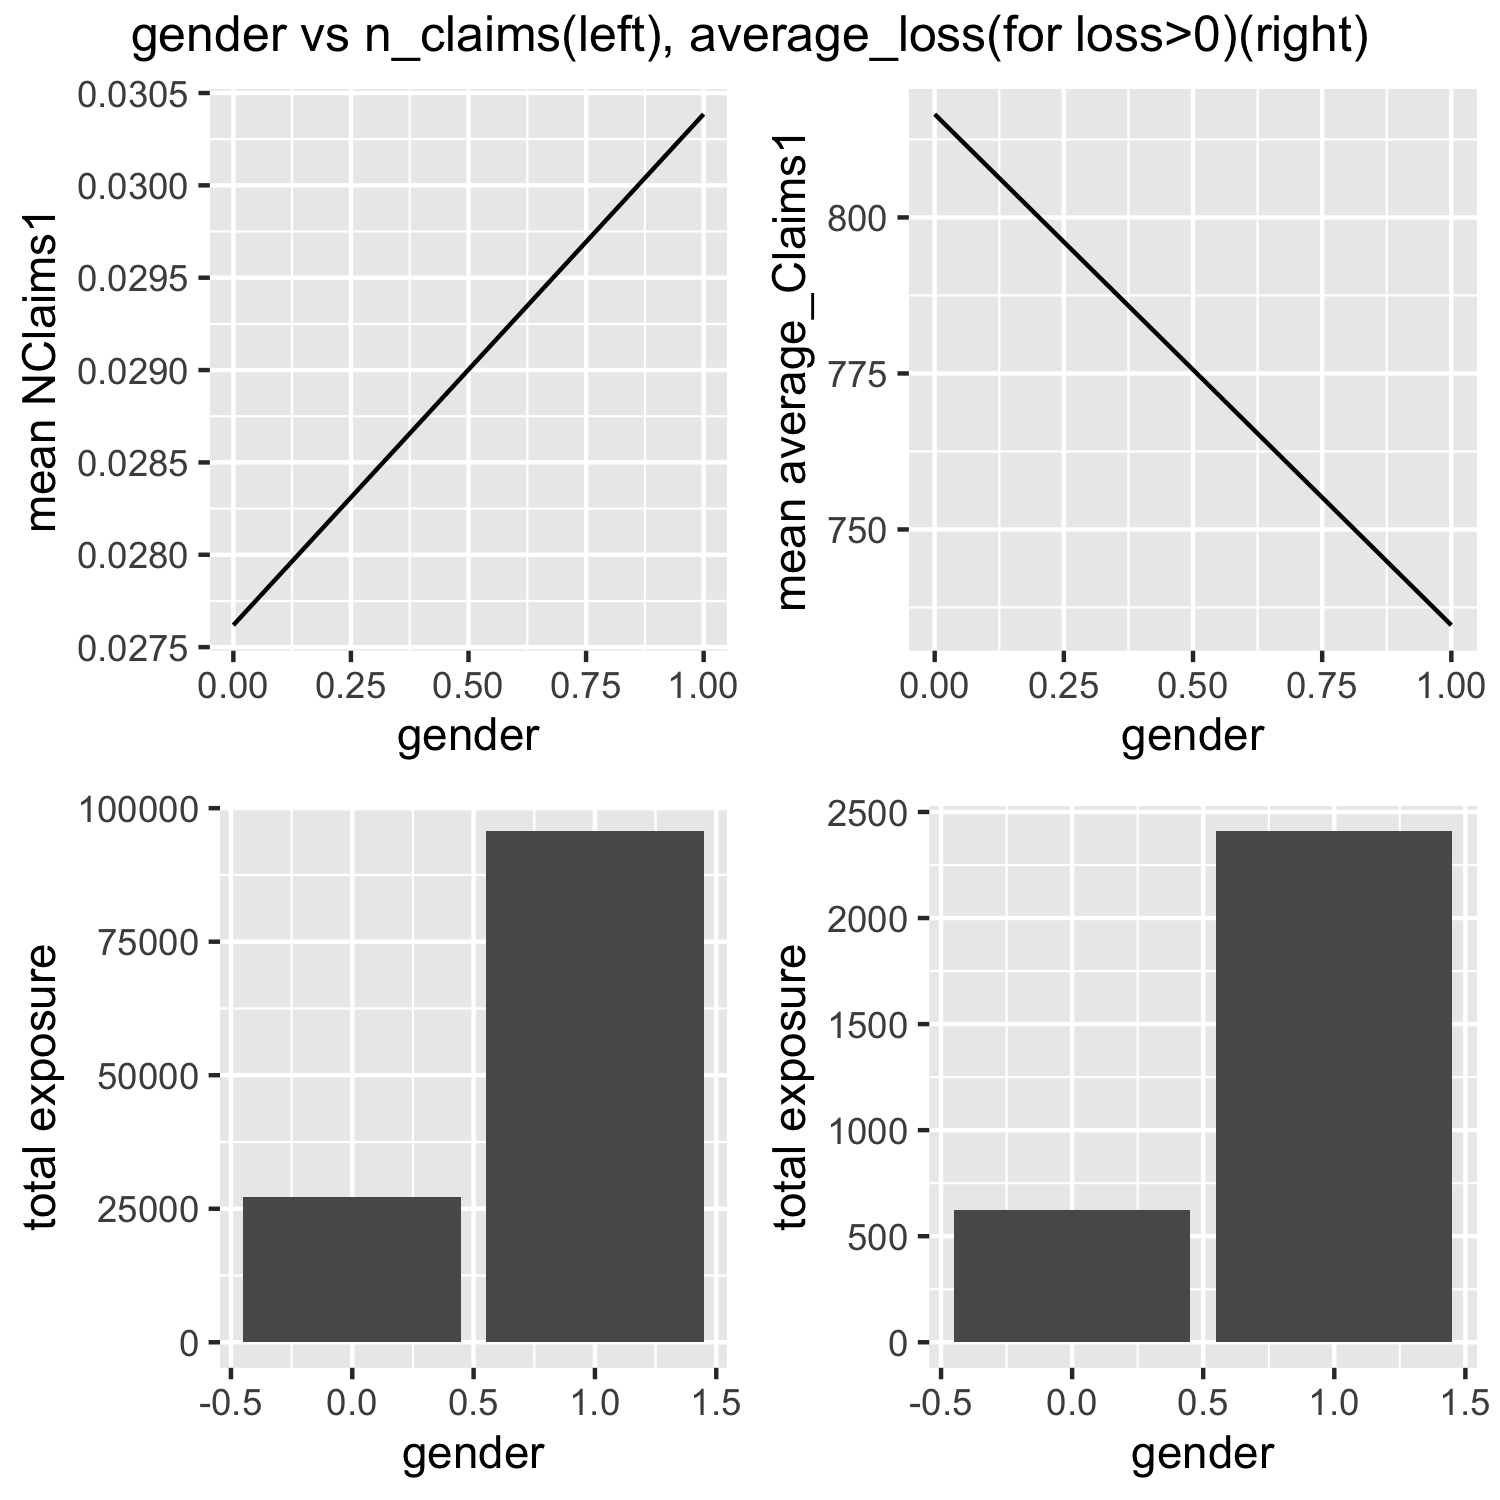

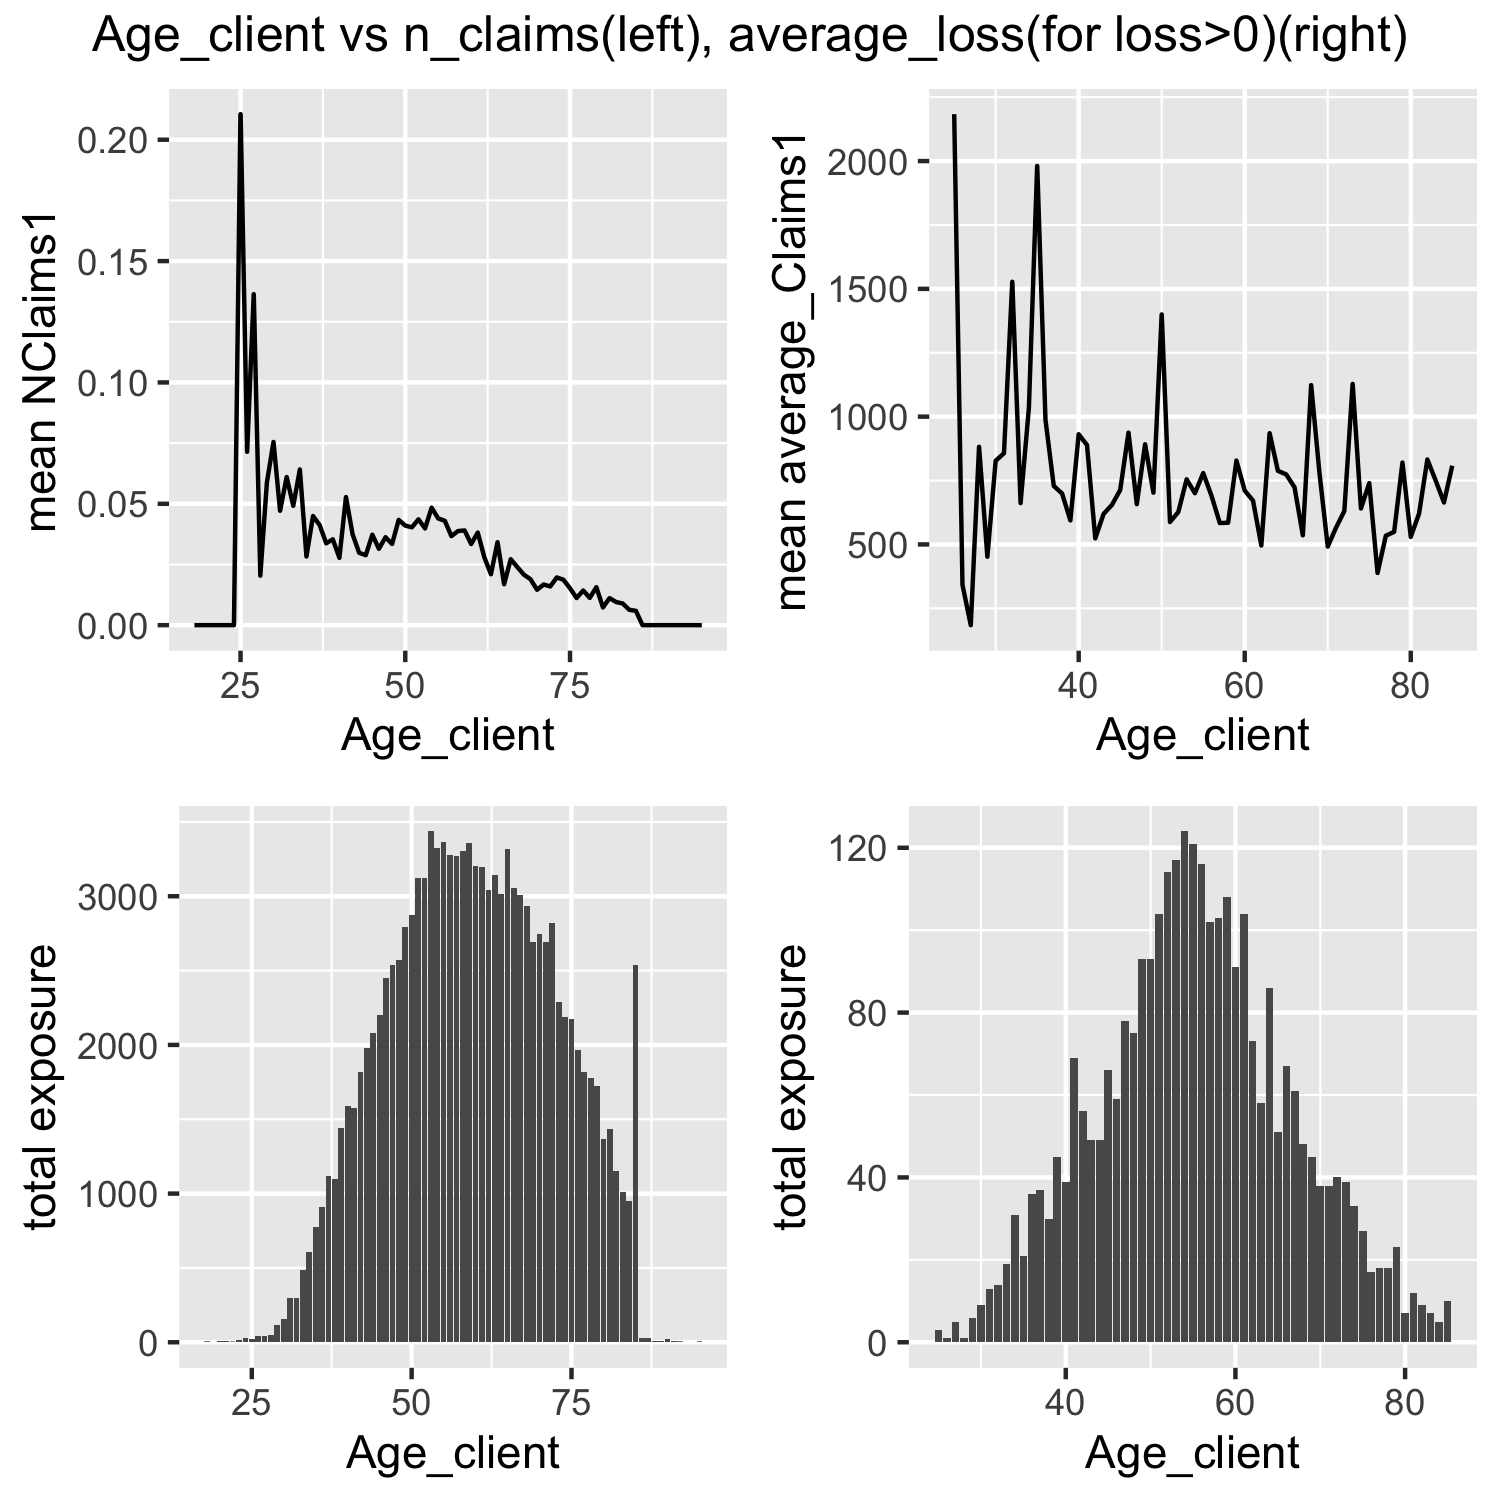

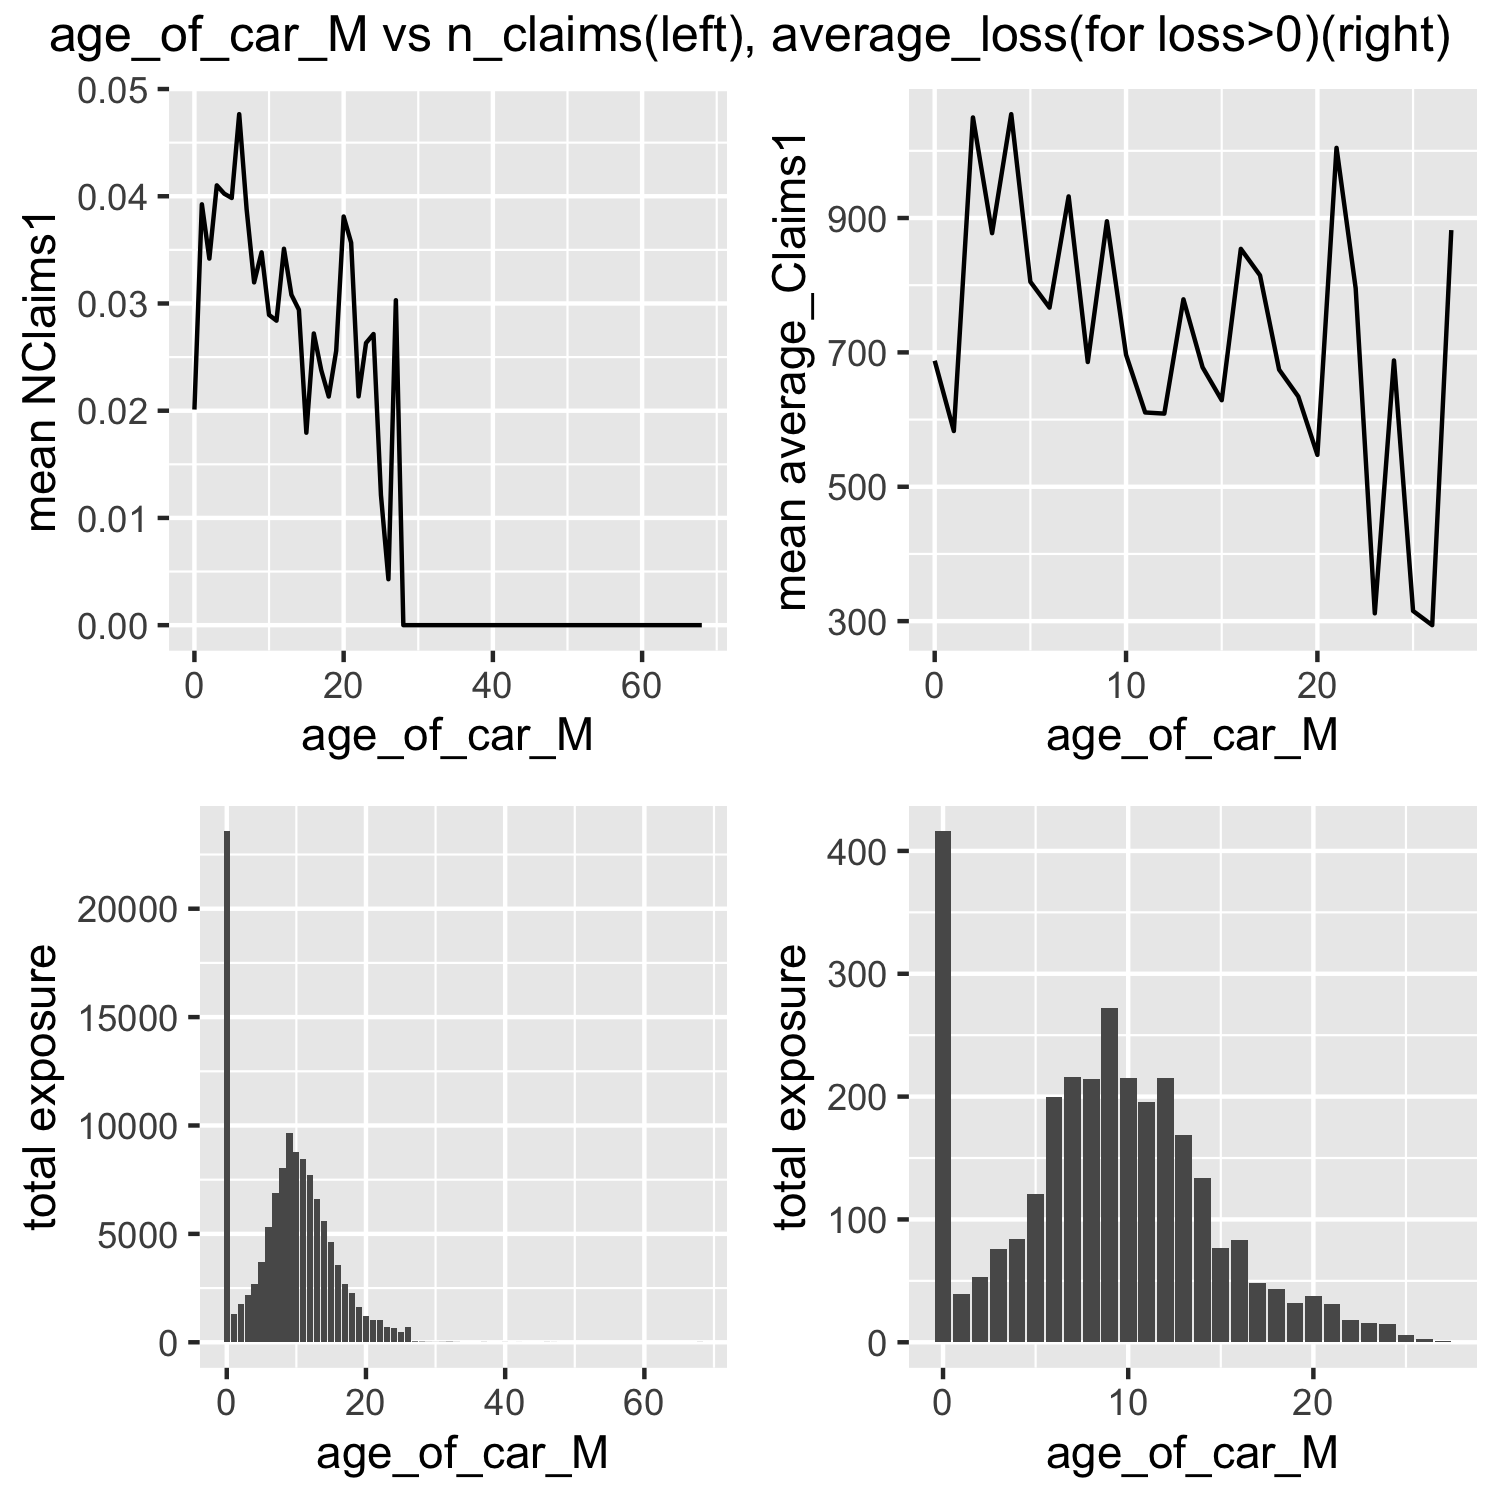

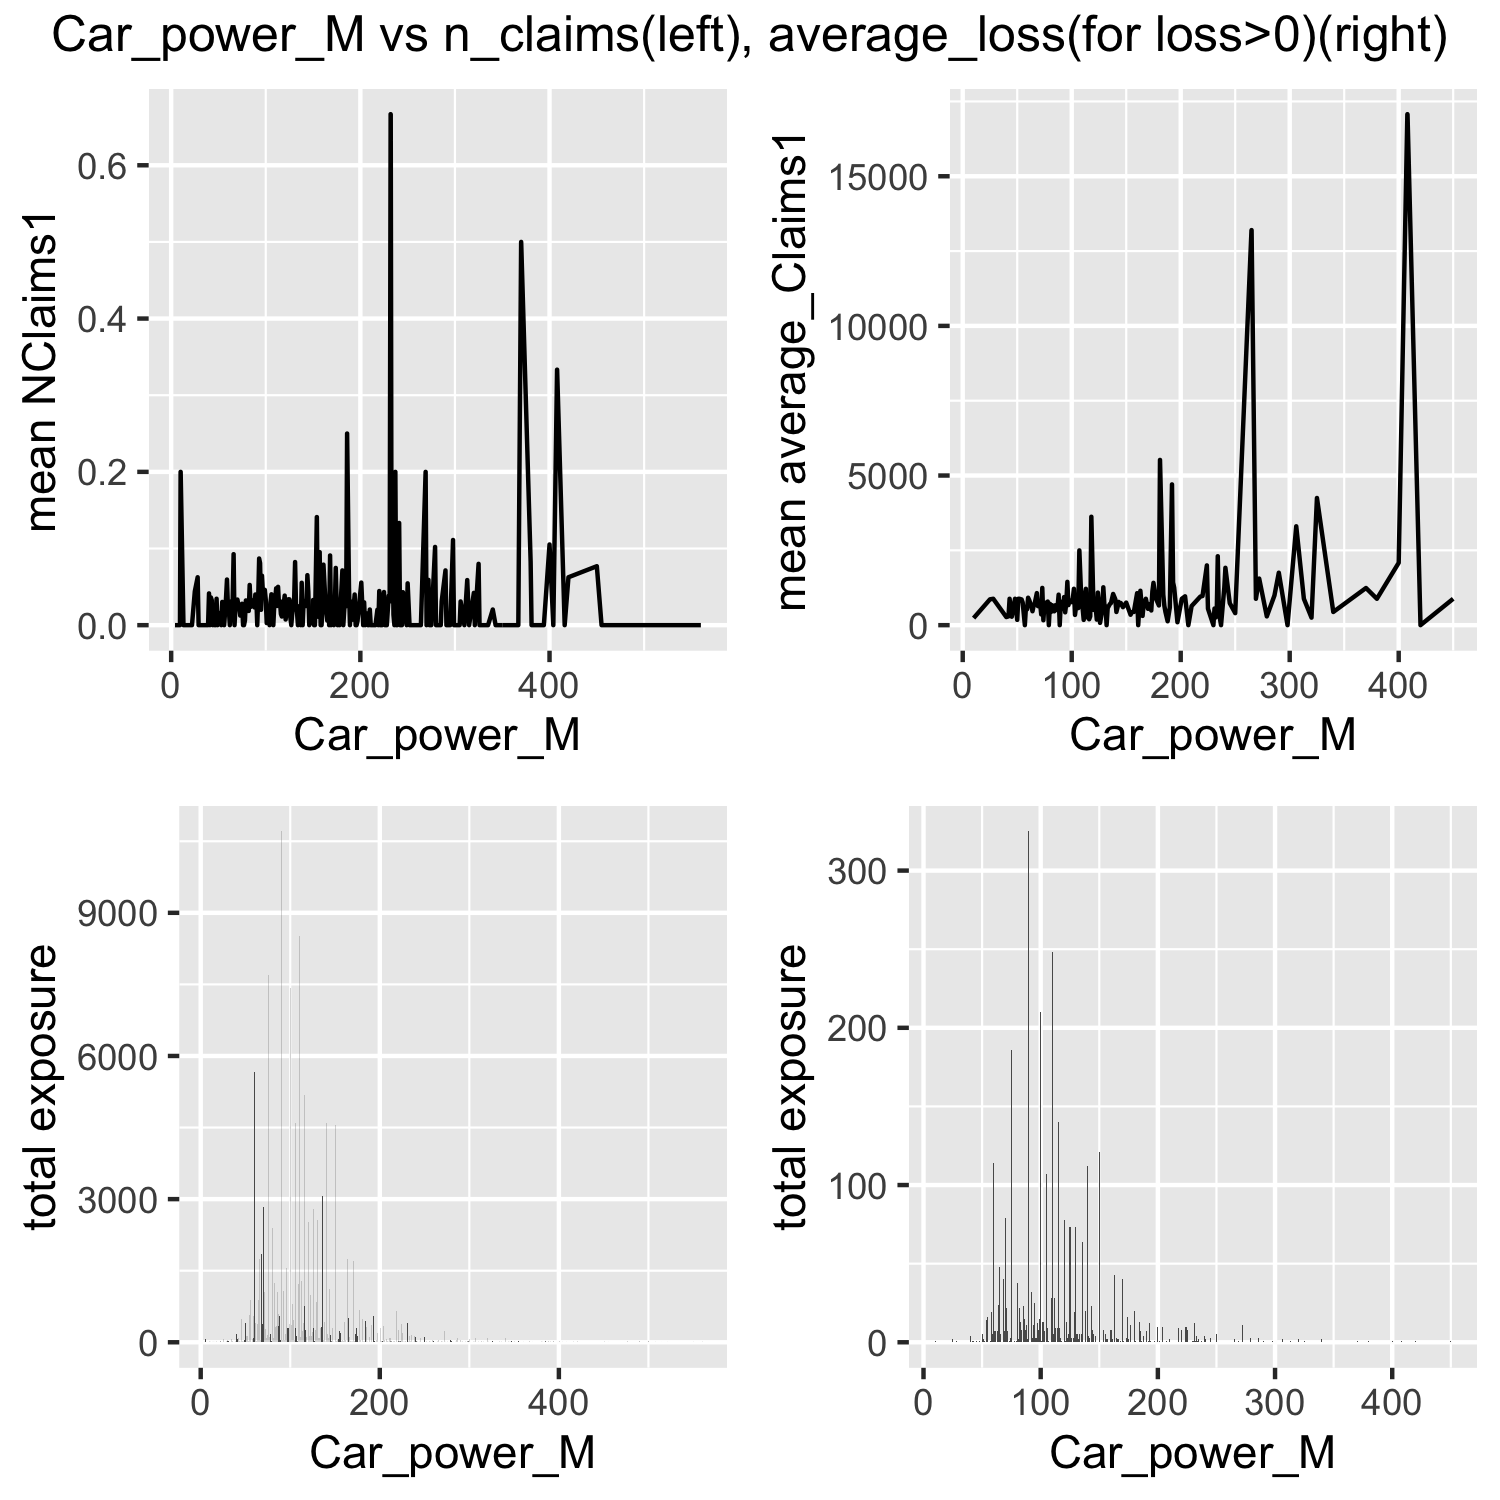

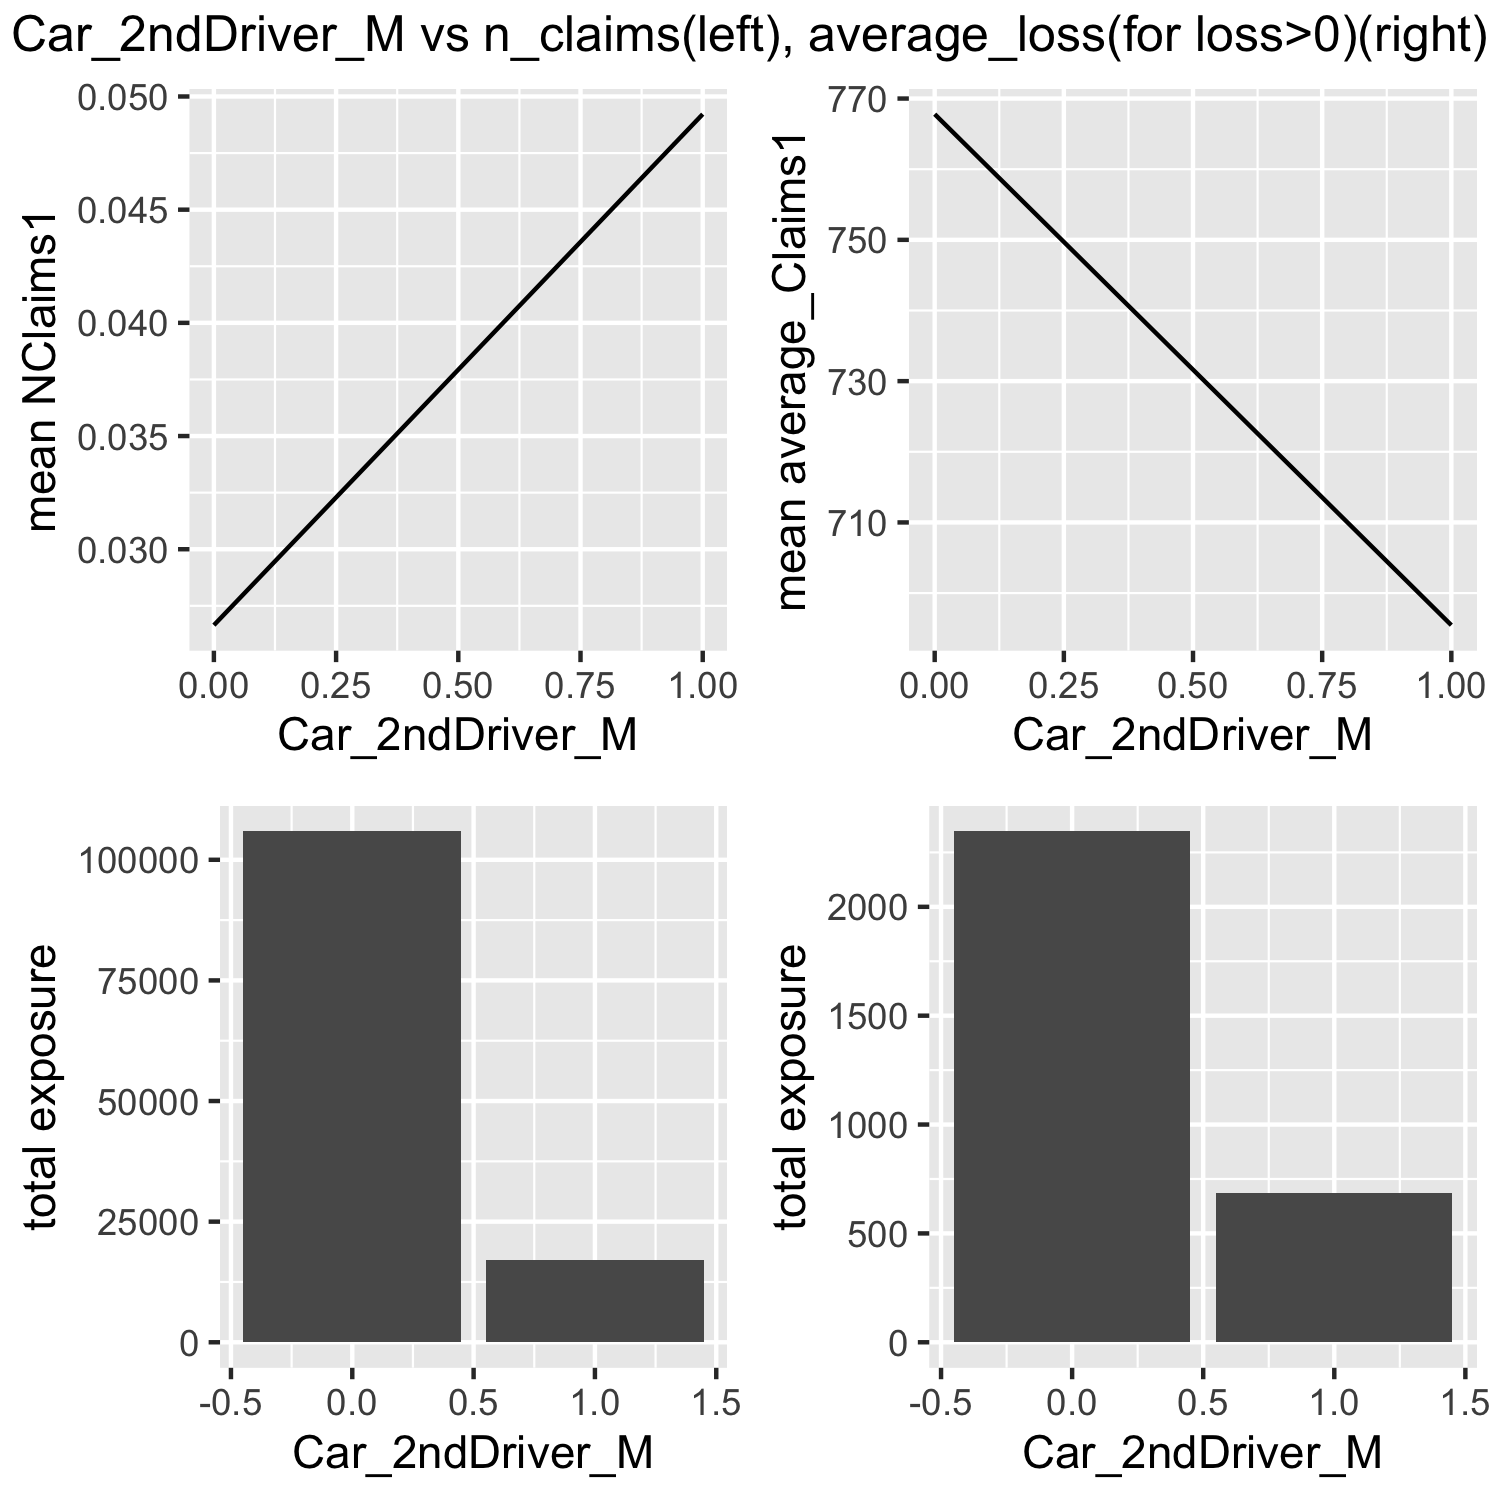

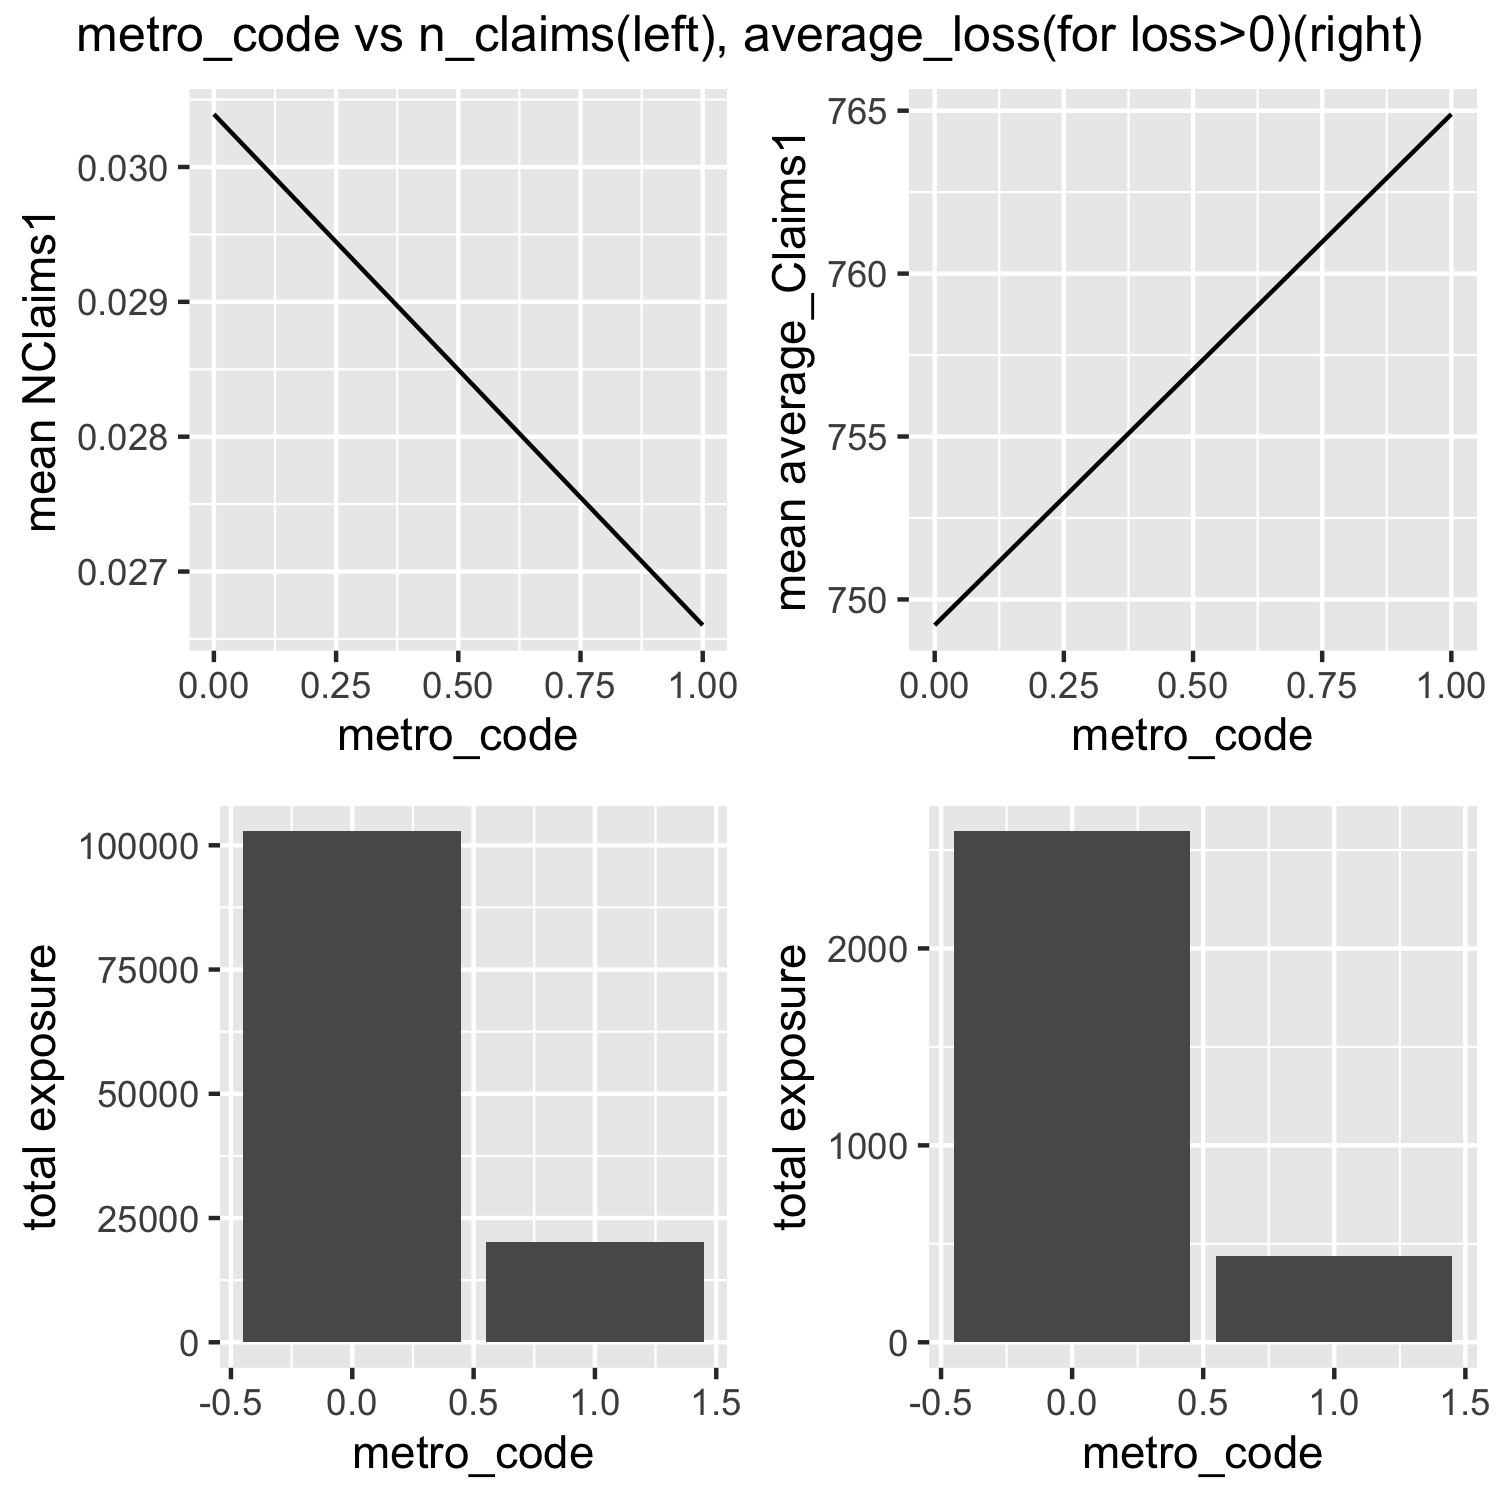

In [35]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 300)
x <- c(
    "year",
    "gender",
    "Age_client",
    "age_of_car_M",
    "Car_power_M",
    "Car_2ndDriver_M",
    "metro_code"
)
for (column_name in x){
    p_n_claims <- visualize_barplot(df, "NClaims1", column_name)
    p_average_loss <- visualize_barplot(df[df$NClaims1>0, ], column_y="average_Claims1", column_x=column_name)
    grid.arrange(p_n_claims[["freq"]], p_average_loss[["freq"]],
                 p_n_claims[["exposure"]], p_average_loss[["exposure"]],
                 nrow=2, ncol=2, top=paste(column_name, "vs n_claims(left), average_loss(for loss>0)(right)"))
    }